# Transport map from samples
The objective of this example is to show how a transport map can be build in MParT when samples from the target density are known.

## Problem formulation
From the definition of a transport map, the *function* $S(\mathbf{x}; \mathbf{w})$ is invertible and have a positive definite Jacobian for any parameters $w$.  Combined with a probability density $\eta(\mathbf{r})$, we 
can therefore define a density $\tilde{\pi}_w(x)$ induced by transforming $r$ with the inverse map $S^{-1}(\mathbf{r})$.   More precisely, the change of random variable formula from the reference $\eta$ to the target $\tilde{\pi}$ reads: 

$$
\tilde{\pi}_{\mathbf{w}}(\mathbf{x}) = \eta(S(\mathbf{x}; \mathbf{w}))\left| \det\nabla S(\mathbf{x}; \mathbf{w})\right|,
$$ 

where $\det\nabla S$ is the determinant of the map Jacobian at the point $\mathbf{x}$.   We refer to $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ as the *map-induced* density or *pullback distribution* and will commonly interchange notation for densities and measures to use the notation $\tilde{\pi} = S^{\sharp} \eta$.

The objective of this example is, from samples $\mathbf{x}^i$, $i \in \{1,...,n\}$ drawn according to a density $\pi$, build the map-induced density approximation $\tilde{\pi}$.

## Imports
First, import MParT and other packages used in this notebook. Note that it is possible to specify the number of threads used by MParT by setting the `KOKKOS_NUM_THREADS` environment variable **before** importing MParT.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import os
os.environ['KOKKOS_NUM_THREADS'] = '8'

import mpart as mt
print('Kokkos is using', mt.Concurrency(), 'threads')
plt.rcParams['figure.dpi'] = 110

Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
  process threads available :   4,  requested thread :   8


Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
                                    Detected: 4 cores per node.
                                    Detected: 1 MPI_ranks per node.
                                    Requested: 8 threads per process.


Kokkos is using 8 threads


## Reference density and samples

In this example we use a 2D target density known as the *banana* density where the unnormalized probability density, samples and the exact transport map are known.

The banana density is defined as:
$$
\pi(x_1,x_2) \propto N_1(x_1)\times N_1(x_2-x_1^2)
$$
where $N_1$ is the 1D standard normal density.

The exact transport map that transport $\pi$ to the 2D standard normal density is defined as:
$$
    {S}^\text{true}(x_1,x_2)=
    \begin{bmatrix}
x_1\\
x_2 - x_1^2
\end{bmatrix}
$$

Samples from $\pi$ are generated by the following:

In [2]:
# Make target samples for training
num_points = 10000
r = np.random.randn(2,num_points)
x1 = r[0]
x2 = r[1] + r[0]**2
x = np.vstack([x1,x2])


# Make target samples for testing
test_r = np.random.randn(2,5000)
test_x1 = test_r[0]
test_x2 = test_r[1] + test_r[0]**2
test_x = np.vstack([test_x1,test_x2])

### Plot training samples:

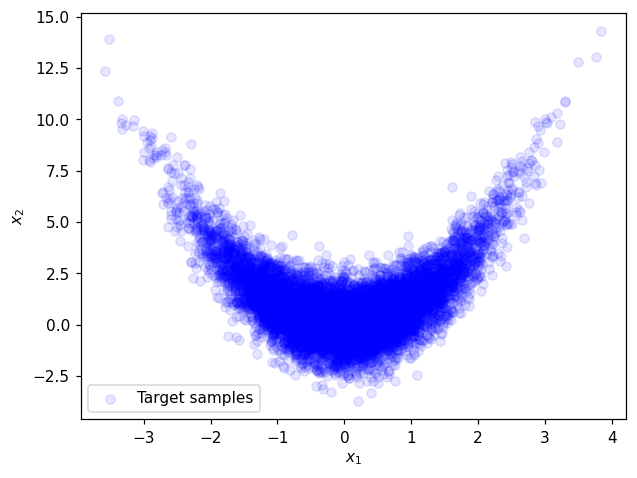

In [3]:
plt.figure()
plt.scatter(x[0,:],x[1,:], facecolor='blue', alpha=0.1, label='Target samples')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Map training

### Defining objective function and its gradient

To match the map induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ with the samples, we can maximize the likelihood of observing the samples, which is simply 
$$
\prod_{i=1}^N \tilde{\pi}_w(\mathbf{x}^i).
$$

Numerically, it is typically easier to work with the log-likelihood instead and we will therefore maximize the log likelihood to find the parameters $w$:

$$
w^\ast = \underset{\mathbf{w}}{\operatorname{argmax}} \sum_{i=1}^N \log \tilde{\pi}_{\mathbf{w}}(\mathbf{x}^i).
$$

Importantly, our use of triangular maps and a standard normal reference density allows us to expand this objective into two independent problems: one for the parameters $w_1$ defining the first component $S_1(x_1; w_1)$ of the map, and one for the parameters defining the second component $S_2(x_{1:2}; w_2)$. 
In general, for map component $k$, the objective function is given by 

$$
J_k(\mathbf{w}_k) = - \frac{1}{N}\sum_{i=1}^N \left( \log\eta\left(S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) + \log \frac{\partial S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k}\right)
$$

and the resulting optimization problem is 

$$
\mathbf{w}_k^\ast = \underset{\mathbf{w}_k}{\operatorname{argmin}} J_k(\mathbf{w}_k).
$$

In order to use efficient gradient-based minimizer we need to define both the objective and its gradient.  The gradient is given by

$$
\nabla_{\mathbf{w}_k}J_k(\mathbf{w}_k) = - \frac{1}{N}\sum_{i=1}^N \left(\left[\nabla_{\mathbf{w}_k}S_k
(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right]^T \nabla_\mathbf{r}\log \eta \left(S_k
(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) - \frac{\partial \nabla_{\mathbf{w}_k}S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k} \left[\frac{\partial S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k}\right]^{-1}\right),
$$

where $\nabla_{\mathbf{w}_k}S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)$ is the Jacobian of the map output with respect to the map parameters and $\nabla_\mathbf{r}\log \eta \left(S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right)$ is the gradient of the reference log-density evaluated at the map output.  Note that for a standard normal reference density, this expression simplifies to $\nabla_\mathbf{r}\log \eta \left(S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) = -S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)$.

In [4]:
# Reference density
rho1 = multivariate_normal(np.zeros(1),np.eye(1))

# Negative log likelihood objective
def obj(coeffs, tri_map,x):
    """ Evaluates the log-likelihood of the samples using the map-induced density. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Compute the map-induced density at each point 
    map_of_x = tri_map.Evaluate(x)
    rho_of_map_of_x = rho1.logpdf(map_of_x.T)
    log_det = tri_map.LogDeterminant(x)

    # Return the negative log-likelihood of the entire dataset
    return -np.sum(rho_of_map_of_x + log_det)/num_points
    
def grad_obj(coeffs, tri_map, x):
    """ Returns the gradient of the log-likelihood objective wrt the map parameters. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Evaluate the map
    map_of_x = tri_map.Evaluate(x)

    # Now compute the inner product of the map jacobian (\nabla_w S) and the gradient (which is just -S(x) here)
    grad_rho_of_map_of_x = -tri_map.CoeffGrad(x, map_of_x)

    # Get the gradient of the log determinant with respect to the map coefficients
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points

### Map parameterization

With the separability property of the objective function mentionned above we can parameterize and optimize components $S_1$ and $S_2$ independently.


#### First component $S_1$

Theoritically the first component is $S_1^{\text{true}}(x_1)=x_1$. This parameterization can be set with MParT as:

In [5]:
multis1 = np.array([[0],[1]]); 
mset1= mt.MultiIndexSet(multis1)
fixed_mset1 = mset1.fix(True)

Let's define the first component:

In [6]:
# Set-up first component and initialize map coefficients
map_options1 = mt.MapOptions()

# Create map component
S1 = mt.CreateComponent(fixed_mset1,map_options1)

#### Second component $S_2$

Theoritically the second component is $S_2^{\text{true}}(x_1,x_2)=x_2^2-x_1$. The corresponding multi-index set can exactly be define as:

In [7]:
multis2_true = np.array([[0,1],[2,0]]); 
mset2_true = mt.MultiIndexSet(multis2_true)
fixed_mset2_true = mset2_true.fix(True)

Other multi-index sets which include the true multi-index set are any total order expansion of order greater than one:

In [8]:
total_order2 = 2
fixed_mset2 = mt.FixedMultiIndexSet(2,total_order2)

This parameterization will include terms: $x_1$, $x_2^2$, $x_1 x_2$ that are not required to approximate the true map.

Let's define $S_2$ with one multi-index set.

In [9]:
map_options2 = mt.MapOptions()
S2 = mt.CreateComponent(fixed_mset2,map_options2) #or S2 = mt.CreateComponent(fixed_mset2_true,map_options2)

### Approximation before optimization

Coefficients of map components are set to 0 upon creation. The triangular transport map composed by $S_1$ and $S_2$ is defined by:

In [10]:
transport_map = mt.TriangularMap((S1,S2))
transport_map.SetCoeffs(np.concatenate((S1.CoeffMap(),S2.CoeffMap())))

Reference density:

In [11]:
# For plotting and computing reference density 
ref_distribution = multivariate_normal(np.zeros(2),np.eye(2))  #standard normal
t = np.linspace(-5,5,100)
grid = np.meshgrid(t,t)
ref_pdf_at_grid = ref_distribution.pdf(np.dstack(grid))

Transport of target samples via $S$:

In [12]:
r_test_before_opt = transport_map.Evaluate(test_x)

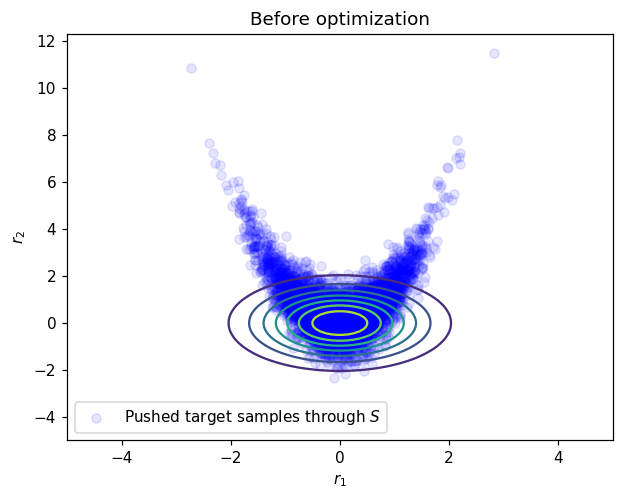

Starting coeffs component 1:
[0. 0.]
Objective value for component 1: 1.52E+00
Starting coeffs component 2:
[0. 0. 0. 0. 0. 0.]
Objective value for component 2: 2.22E+00


In [13]:
# Before optimization plot
plt.figure()
plt.title('Before optimization')
plt.contour(*grid, ref_pdf_at_grid)
plt.scatter(r_test_before_opt[0,:],r_test_before_opt[1,:], facecolor='blue', alpha=0.1, label='Pushed target samples through $S$')
plt.legend()
plt.xlabel('$r_1$')
plt.ylabel('$r_2$')
plt.show()


# Print initial coeffs and objective values
print('==================')
print('Starting coeffs component 1:')
print(S1.CoeffMap())
print('Objective value for component 1: {:.2E}'.format(obj(S1.CoeffMap(), S1, test_x[:1,:])))
print('==================')
print('Starting coeffs component 2:')
print(S2.CoeffMap())
print('Objective value for component 2: {:.2E}'.format(obj(S2.CoeffMap(), S2, test_x)))
print('==================')

### Optimization

Optimization of $S_1$ and $S_2$ coefficients are performed independently.

#### Optimization of $S_1$

For $S_1$ only samples of the first coordinate $x_1$ are required to solve the minimization problem.

In [14]:
# Optimize
optimizer_options={'gtol': 1e-5, 'disp': True}
res = minimize(obj, S1.CoeffMap(), args=(S1, x[:1,:]), jac=grad_obj, method='BFGS', options=optimizer_options)

Optimization terminated successfully.
         Current function value: 1.425226
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


#### Optimization of $S_2$

In [15]:
# Optimize
optimizer_options={'gtol': 1e-5, 'disp': True}
res = minimize(obj, S2.CoeffMap(), args=(S2, x), jac=grad_obj, method='BFGS', options=optimizer_options)

Optimization terminated successfully.
         Current function value: 1.414791
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18


### Approximation after optimization

#### Normality of pushed samples:



Coefficients of `transport_map` are now updated, let's transport testing samples again:

In [16]:
r_test_after_opt = transport_map.Evaluate(test_x)

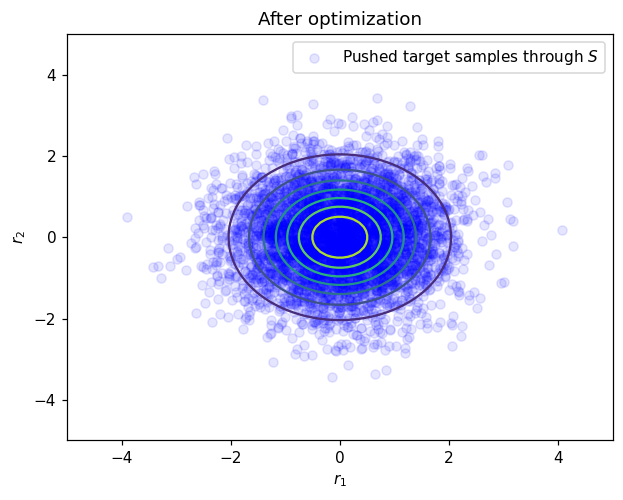

Final coeffs component 1:
[0.00849893 0.84131668]
Objective value for component 1: 1.41E+00
Final coeffs component 2:
[-1.00899706  0.86291349  0.00314095  0.01513377 -0.002531   -2.23750783]
Objective value for component 2: 1.40E+00


In [17]:
# After optimization plot
plt.figure()
plt.title('After optimization')
plt.contour(*grid, ref_pdf_at_grid)
plt.scatter(r_test_after_opt[0,:],r_test_after_opt[1,:], facecolor='blue', alpha=0.1, label='Pushed target samples through $S$')
plt.legend()
plt.xlabel('$r_1$')
plt.ylabel('$r_2$')
plt.show()


# Print final coeffs and objective
print('==================')
print('Final coeffs component 1:')
print(S1.CoeffMap())
print('Objective value for component 1: {:.2E}'.format(obj(S1.CoeffMap(), S1, test_x[:1,:])))
print('==================')
print('Final coeffs component 2:')
print(S2.CoeffMap())
print('Objective value for component 2: {:.2E}'.format(obj(S2.CoeffMap(), S2, test_x)))
print('==================')

After optimization testing samples are visually distributed according to the standard normal which tell us that the map has been computed accurately. Another estimation of the approximation quality is to test normality of the pushed samples. One simple way to do that is to compute first moments of the pushed test samples:

In [18]:
# Print statistics of normalized samples 
print('==================')
mean_of_map = np.mean(r_test_after_opt,1)
print("Mean of normalized test samples")
print(mean_of_map)
print('==================')
print("Cov of normalized test samples")
cov_of_map = np.cov(r_test_after_opt)
print(cov_of_map)
print('==================')

Mean of normalized test samples
[0.00522951 0.01503834]
Cov of normalized test samples
[[0.96889399 0.01897448]
 [0.01897448 0.97549654]]


Here mean should be 0 and covariance matrix should be identity.

#### Comparison with the true transport map

Since the true transport map for this problem is known, we can compare directly map evaluations component by component.

In [19]:
# Evaluation grid

ngrid=100
x1_t = np.linspace(-3,3,ngrid)
x2_t = np.linspace(-3,7.5,ngrid)
xx1,xx2 = np.meshgrid(x1_t,x2_t)

xx = np.vstack((xx1.reshape(1,-1),xx2.reshape(1,-1)))

##### First component

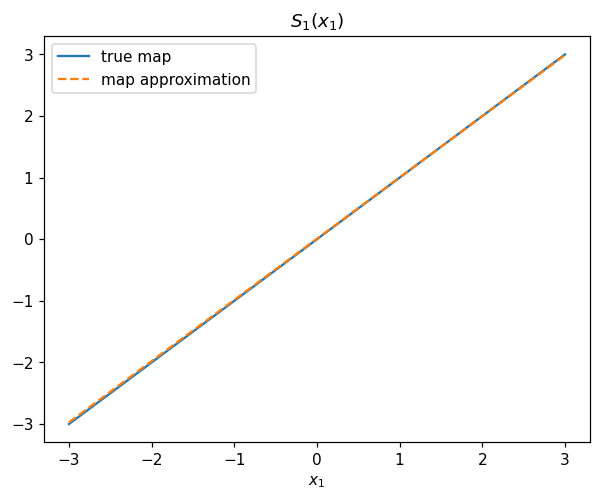

In [20]:
plt.figure()
plt.title('$S_1(x_1)$')
plt.plot(x1_t,x1_t,label='true map')
plt.plot(x1_t,S1.Evaluate(x1_t.reshape(1,-1)).flatten(),'--',label='map approximation')
plt.xlabel('$x_1$')
plt.legend()
plt.show()

##### Second component

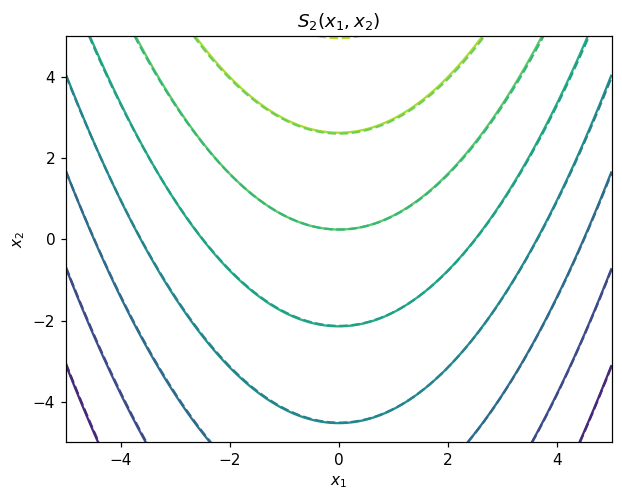

In [21]:
map_eval_true =  xx[1,:] - xx[0,:]**2
map_eval_approx = S2.Evaluate(xx)

plt.figure()
plt.title('$S_2(x_1,x_2)$')
plt.contour(*grid, map_eval_true.reshape(100,100))
plt.contour(*grid, map_eval_approx.reshape(100,100),linestyles='--')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

#### Contours of map-induced density

We can also compare contours of the map-induced density and true unnormalized density. 

In [22]:
# Map induced pdf
def pullback_pdf(tri_map,rho,x):
    r = tri_map.Evaluate(x)
    log_pdf = rho.logpdf(r.T)+tri_map.LogDeterminant(x)
    return np.exp(log_pdf)

# True density
def target_logpdf(x):
  rv1 = multivariate_normal(np.zeros(1),np.eye(1))
  rv2 = multivariate_normal(np.zeros(1),np.eye(1))
  logpdf1 = rv1.logpdf(x[0])
  logpdf2 = rv2.logpdf(x[1]-x[0]**2)
  logpdf = logpdf1 + logpdf2
  return logpdf

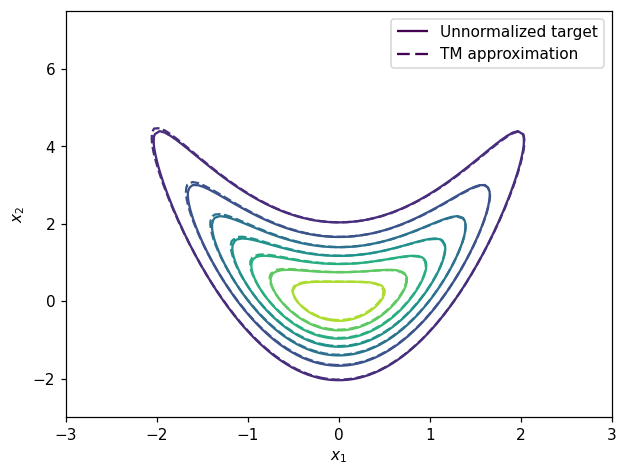

In [23]:
# Comparison grid

ngrid=100
x1_t = np.linspace(-3,3,ngrid)
x2_t = np.linspace(-3,7.5,ngrid)
xx1,xx2 = np.meshgrid(x1_t,x2_t)

xx = np.vstack((xx1.reshape(1,-1),xx2.reshape(1,-1)))

# For plotting and computing densities

true_pdf_at_grid = np.exp(target_logpdf(xx))

map_induced_pdf = pullback_pdf(transport_map,ref_distribution,xx)

fig, ax = plt.subplots()
#SCA = ax.scatter(test_x[0,:2000],test_x[1,:2000], facecolor='blue', alpha=0.1,label='Target samples')
CS1 = ax.contour(xx1, xx2, true_pdf_at_grid.reshape(ngrid,ngrid))
CS2 = ax.contour(xx1, xx2, map_induced_pdf.reshape(ngrid,ngrid),linestyles='--')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
legend1 = ax.legend([h1[0], h2[0]], ['Unnormalized target', 'TM approximation'])
plt.show()